In [5]:
"""
Reproduction of Section 6.4: "Husky vs Wolf"
Goal: Show that a model trained on biased data (Wolf=Snow) relies on the background.
"""

import sys
import os
import glob
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from sklearn.linear_model import LogisticRegression

# Project imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.explainers.lime_image import LimeImageExplainer
from src.utils.visualization import Visualizer

# --- Configuration ---
DATA_DIR = os.path.join("data", "raw", "husky_vs_wolf")
TRAIN_WOLF_DIR = os.path.join(DATA_DIR, "train", "wolf_snow")
TRAIN_HUSKY_DIR = os.path.join(DATA_DIR, "train", "husky_grass")
TEST_IMAGE_PATH = os.path.join(DATA_DIR, "val", "husky_snow") # The Trick Image

# --- 1. Feature Extraction Helper ---
class FeatureExtractor:
    """
    Uses InceptionV3 to extract high-level feature vectors.
    We don't train Inception; we just use it as an eye.
    """
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Loading InceptionV3 on {self.device}...")
        
        # Load Pretrained Inception V3
        self.model = models.inception_v3(pretrained=True)
        self.model.eval()
        self.model.to(self.device)
        
        # Standard Inception Transforms
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def get_embedding(self, img_path):
        """Read image and return (1, 1000) vector"""
        img = Image.open(img_path).convert('RGB')
        t_img = self.transform(img).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            # Inception returns logits. We use them as features.
            preds = self.model(t_img)
        return preds.cpu().numpy()

    def get_embedding_batch(self, images):
        """
        For LIME: Takes a numpy array of images (N, H, W, 3), 
        converts to Tensor, and gets embeddings.
        """
        batch_tensors = []
        for img in images:
            # Img is numpy 0-1 or 0-255. Convert to PIL for easy transform.
            # LIME passes float64 0-1.
            pil_img = Image.fromarray((img * 255).astype('uint8'))
            batch_tensors.append(self.transform(pil_img))
        
        batch_input = torch.stack(batch_tensors).to(self.device)
        
        with torch.no_grad():
            preds = self.model(batch_input)
        
        return preds.cpu().numpy()




In [6]:
def run_experiment():
    print("--- STARTING DUMB MODEL EXPERIMENT ---")
    
    # --- Helper: Dumb Feature Extractor (Raw Pixels) ---
    # We resize to 100x100 to keep the feature vector size manageable (100*100*3 = 30,000 features)
    # This forces the model to look at colors/blobs rather than deep semantic features.
    IMG_SIZE = (100, 100)
    
    def get_dumb_features(img_path):
        img = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
        # Flatten: (100, 100, 3) -> (30000,)
        return np.array(img).flatten() / 255.0

    # A. Check Data
    if not os.path.exists(TRAIN_WOLF_DIR):
        print(f"Error: Data not found at {TRAIN_WOLF_DIR}")
        return

    # B. Train the 'Bad' Model (Using Raw Pixels)
    X_train = []
    y_train = []
    
    # Load Wolf (Class 1) - Expecting SNOW backgrounds
    print("Processing Wolves (Snow)...")
    wolf_files = glob.glob(os.path.join(TRAIN_WOLF_DIR, "*"))
    for f in wolf_files:
        X_train.append(get_dumb_features(f))
        y_train.append(1) 
        
    # Load Husky (Class 0) - Expecting GRASS backgrounds
    print("Processing Huskies (Grass)...")
    husky_files = glob.glob(os.path.join(TRAIN_HUSKY_DIR, "*"))
    for f in husky_files:
        X_train.append(get_dumb_features(f))
        y_train.append(0)
        
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    print(f"Training Logistic Regression on {len(X_train)} images (Raw Pixels)...")
    # We need a stronger regularization (C is lower) or just standard default
    # because raw pixels are noisy.
    bad_model = LogisticRegression(C=0.1, random_state=42, max_iter=1000)
    bad_model.fit(X_train, y_train)
    
    print(f"Training Accuracy: {bad_model.score(X_train, y_train):.2f}")
    
    # C. The Trap: Predict on 'Husky on Snow'
    print("\n--- Testing on 'Husky on Snow' ---")
    test_files = glob.glob(os.path.join(TEST_IMAGE_PATH, "*"))
    if not test_files:
        print("No test image found")
        return
        
    target_img_path = test_files[0]
    # LIME needs the image in original size for segmentation (or at least viewable size)
    # We keep it 299x299 for the human eye and segmentation
    target_img = np.array(Image.open(target_img_path).convert('RGB').resize((299, 299))) / 255.0
    
    # Get embedding for prediction (using the dumb resize)
    test_feat = get_dumb_features(target_img_path).reshape(1, -1)
    
    prediction = bad_model.predict(test_feat)[0]
    probs = bad_model.predict_proba(test_feat)[0]
    
    class_names = ['Husky', 'Wolf']
    print(f"Prediction: {class_names[prediction]} (Conf: {probs[prediction]:.2f})")
    
    if prediction == 1:
        print("\nSUCCESS: The model incorrectly predicted 'Wolf'!")
        print("Likely cause: It sees the SNOW.")
    else:
        print("\nNote: Model predicted Husky. We will visualize WHY.")
        print("If the explanation highlights the green grass patches or dark spots, it's still relying on background.")

    # D. Explain with LIME
    print("\n--- Explaining the Prediction ---")
    
    # Define the prediction function for LIME
    # LIME gives us (N, 299, 299, 3) images. 
    # We must resize them to (100, 100) and flatten them to match training.
    def classifier_fn(images):
        # images is a numpy array of shape (N, 299, 299, 3)
        dumb_feats = []
        for img in images:
            # img is float 0-1. Convert to PIL to resize.
            pil_img = Image.fromarray((img * 255).astype('uint8')).resize(IMG_SIZE)
            dumb_feats.append(np.array(pil_img).flatten() / 255.0)
        
        return bad_model.predict_proba(np.array(dumb_feats))
    
    explainer = LimeImageExplainer(random_state=42)
    
    # Explain whatever class was predicted
    explanation = explainer.explain_instance(
        target_img, 
        classifier_fn, 
        labels=(prediction,), # <--- FIX: Explain the predicted class
        hide_color=0, 
        num_samples=1000 
    )
    
    # E. Visualize
    viz = Visualizer()
    output_path = "husky_wolf_explanation.png"
    
    # Visualize the PREDICTED class
    viz.visualize_image_mask(target_img, explanation[prediction], num_features=5, save_path=output_path)
    
    print(f"\nDone! Check '{output_path}'.")
    if prediction == 1: 
        print("Look for SNOW being highlighted.")
    else:
        print("Look at what features the model actually used.")

--- STARTING DUMB MODEL EXPERIMENT ---
Processing Wolves (Snow)...
Processing Huskies (Grass)...
Training Logistic Regression on 10 images (Raw Pixels)...
Training Accuracy: 1.00

--- Testing on 'Husky on Snow' ---
Prediction: Wolf (Conf: 1.00)

SUCCESS: The model incorrectly predicted 'Wolf'!
Likely cause: It sees the SNOW.

--- Explaining the Prediction ---

Visualizing Top 5 segments for Class 1...
  Segment 0: Weight 0.4605 (Positive)
Explanation saved to husky_wolf_explanation.png

Done! Check 'husky_wolf_explanation.png'.
Look for SNOW being highlighted.


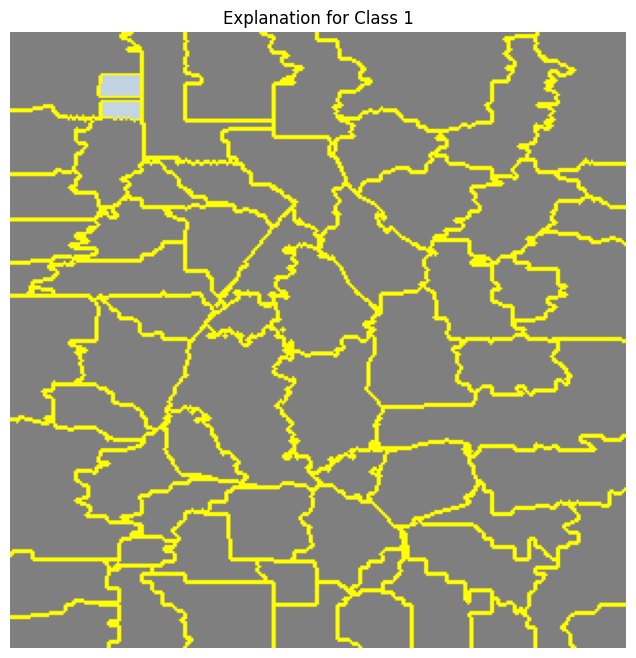

In [7]:
run_experiment()